# Data Analysis Notebook

This notebook demonstrates data analysis techniques including:
- Data loading and preprocessing
- Exploratory data analysis 
- Statistical analysis
- Data visualization


## Setup
Run the cells below to import required libraries and load the dataset.

In [ ]:
%pip install torch torch-geometric numpy pandas matplotlib seaborn rdkit tqdm networkx ipython

In [2]:
#%% import

import torch
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from rdkit import Chem
from rdkit.Chem import Draw
from tqdm import tqdm
from IPython.display import display
import networkx as nx
from torch_geometric.utils import to_networkx
from tabulate import tabulate

#!pip install torch torch-geometric numpy pandas matplotlib seaborn rdkit tqdm networkx ipython
%matplotlib inline

# Tox21 Dataset

The Toxicology in the 21st Century (Tox21) dataset is a public repository of toxicology data 
compiled by the National Center for Advancing Translational Sciences (NCATS). It contains 
measurements on around 10,000 chemical compounds (molecules) tested for 12 different toxic effects.

The 12 toxicity tasks (targets) are:
- NR-AR: Androgen Receptor
- NR-AR-LBD: Androgen Receptor Ligand Binding Domain 
- NR-AhR: Aryl Hydrocarbon Receptor
- NR-Aromatase: Aromatase
- NR-ER: Estrogen Receptor
- NR-ER-LBD: Estrogen Receptor Ligand Binding Domain
- NR-PPAR-gamma: Peroxisome Proliferator Activated Receptor Gamma
- SR-ARE: Nuclear Factor (erythroid-derived 2)-like 2/antioxidant responsive element
- SR-ATAD5: ATPase family AAA domain-containing protein 5
- SR-HSE: Heat Shock Factor Response Element
- SR-MMP: Mitochondrial Membrane Potential
- SR-p53: p53 signaling pathway

Each molecule is represented by its chemical structure (SMILES string) and 12 binary labels 
indicating toxicity for each target (1 = toxic, 0 = non-toxic). Some values may be missing.

The dataset is commonly used for:
- Development of computational toxicity prediction models
- Structure-activity relationship analysis
- Multi-task and transfer learning studies
- Benchmarking molecular machine learning methods

Source: [Tox21 Challenge](https://tripod.nih.gov/tox21/challenge/)


In [3]:
#%% Load dataset and print a summary

dataset = MoleculeNet(root='data/TOX21', name='TOX21')

dataset.get_summary()

MoleculeNet (#graphs=7831):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     18.6 |     38.6 |
| std        |     11.3 |     25   |
| min        |      1   |      0   |
| quantile25 |     11   |     22   |
| median     |     16   |     34   |
| quantile75 |     23   |     50   |
| max        |    132   |    290   |
+------------+----------+----------+

In [ ]:
#%% Graph Statistics (number of nodes, edges, and node degrees)
#useful to understand the dataset graph structure

print("\n=== Graph Statistics ===")
n_nodes = []
n_edges = []
node_degrees = []

for data in tqdm(dataset, desc="Analyzing graphs"):
    n_nodes.append(data.num_nodes)
    n_edges.append(data.num_edges)
    degrees = torch.bincount(data.edge_index[0])
    node_degrees.extend(degrees.tolist())

print(f"Average number of nodes: {np.mean(n_nodes):.2f} ± {np.std(n_nodes):.2f}")
print(f"Average number of edges: {np.mean(n_edges):.2f} ± {np.std(n_edges):.2f}")
print(f"Average node degree: {np.mean(node_degrees):.2f} ± {np.std(node_degrees):.2f}")


=== Graph Statistics ===


Analyzing graphs: 100%|██████████| 7831/7831 [00:00<00:00, 34595.18it/s]

Average number of nodes: 18.57 ± 11.35
Average number of edges: 38.59 ± 25.05
Average node degree: 2.08 ± 0.78


Tox21 dataset:

**Dataset Size:**
The analysis was performed on 7,831 molecular graphs, representing different chemical compounds.

**Node Statistics:**
- Average of 18.57 nodes per molecule with a standard deviation of 11.35.
- This indicates that most molecules in the dataset are relatively small to medium-sized, but there's significant variation in molecular size.
- The high standard deviation suggests a diverse set of molecules from simple to complex structures.

**Edge Statistics:**
- Average of 38.59 edges per molecule with a standard deviation of 25.05.
- The higher number of edges compared to nodes is expected since chemical bonds can include multiple connections between atoms.
- The large standard deviation indicates high variability in molecular connectivity.

**Node Degree:**
- Average node degree of 2.08 with a standard deviation of 0.78.
- This is consistent with typical organic molecules where most atoms (nodes) have 1-4 bonds.
- The relatively low standard deviation suggests that despite varying sizes, the basic chemical connectivity patterns remain similar across molecules.

These statistics suggest the Tox21 dataset contains a diverse but chemically reasonable set of molecular structures, suitable for machine learning applications in toxicity prediction.

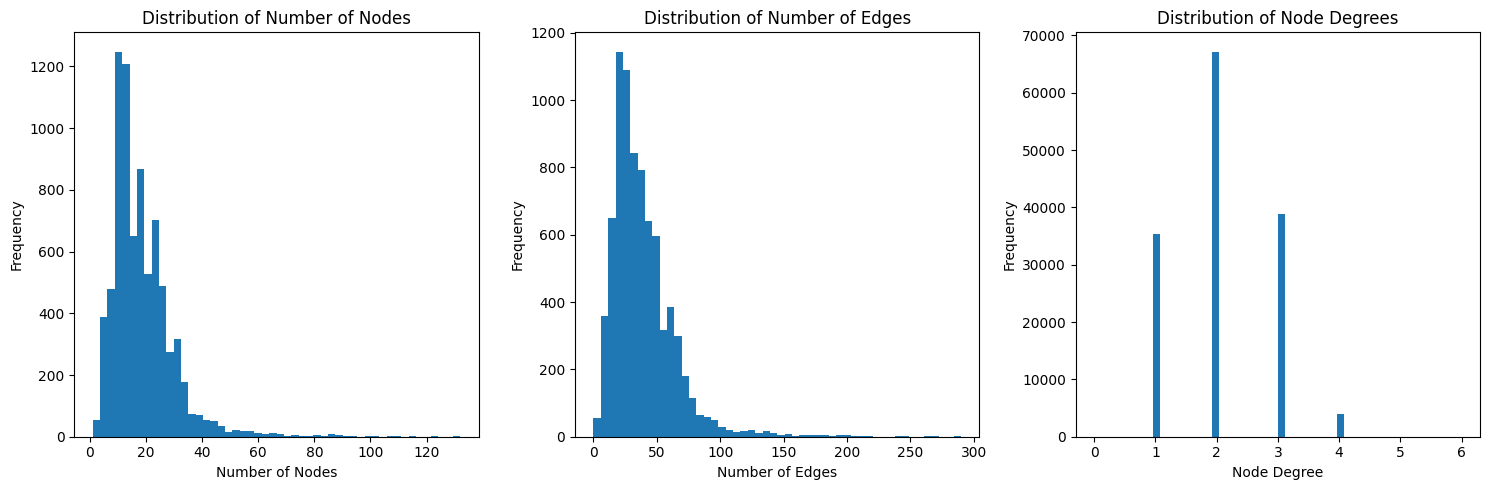

In [ ]:
#%% Visualize distributions of number of nodes, edges, and node degrees

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.hist(n_nodes, bins=50)
ax1.set_title('Distribution of Number of Nodes')
ax1.set_xlabel('Number of Nodes')
ax1.set_ylabel('Frequency')

ax2.hist(n_edges, bins=50)
ax2.set_title('Distribution of Number of Edges')
ax2.set_xlabel('Number of Edges')
ax2.set_ylabel('Frequency')

ax3.hist(node_degrees, bins=50)
ax3.set_title('Distribution of Node Degrees')
ax3.set_xlabel('Node Degree')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
#%% Feature Analysis

print("\n=== Feature Analysis ===")
# Analyze node features
node_features = torch.cat([data.x for data in dataset], dim=0).float()

print("Node Features Statistics:")
print(f"Feature dimensionality: {node_features.shape[1]}")

# Calculate feature statistics
feature_means = node_features.mean(dim=0)
feature_stds = node_features.std(dim=0)


=== Feature Analysis ===
Node Features Statistics:
Feature dimensionality: 9


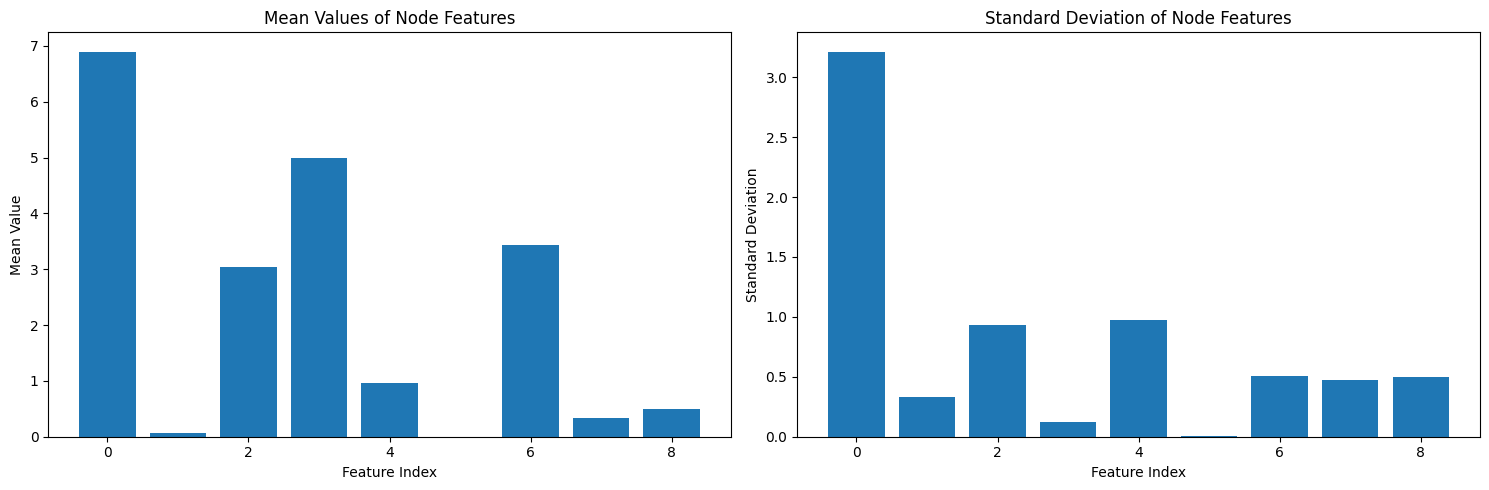

In [ ]:
#%% Plot feature statistics

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(range(len(feature_means)), feature_means)
plt.title('Mean Values of Node Features')
plt.xlabel('Feature Index')
plt.ylabel('Mean Value')

plt.subplot(1, 2, 2)
plt.bar(range(len(feature_stds)), feature_stds)
plt.title('Standard Deviation of Node Features')
plt.xlabel('Feature Index')
plt.ylabel('Standard Deviation')

plt.tight_layout()
plt.show()

# Analysis of Molecular Graph Properties in Tox21 Dataset

## Node Distribution Analysis
The distribution of nodes shows most molecules contain between 10-40 nodes, with a peak around 15-20 nodes. This right-skewed pattern indicates our dataset primarily consists of small to medium-sized drug-like molecules, with some larger compounds extending up to 120 nodes. This aligns well with typical pharmaceutical compound libraries.

## Edge Distribution Patterns
Edge counts closely follow the node distribution, with most molecules having 20-80 edges and peaking at 30-40 edges. This edge-to-node relationship suggests consistent molecular connectivity patterns typical of organic compounds, where atoms form 1-4 bonds following standard valence rules.

## Node Degree Characteristics
The node degree distribution shows clear peaks at degrees 1, 2, and 3, with a smaller presence of degree 4 nodes. These correspond to typical chemical structures: terminal atoms (degree 1), chain/ring atoms (degree 2), branching points (degree 3), and quaternary carbons (degree 4). The absence of higher degrees validates the chemical reasonableness of our molecular representations.

These structural features suggest our toxicity prediction models should focus on processing molecules within these size and connectivity ranges, while accounting for the predominant local chemical environments indicated by the degree distribution.

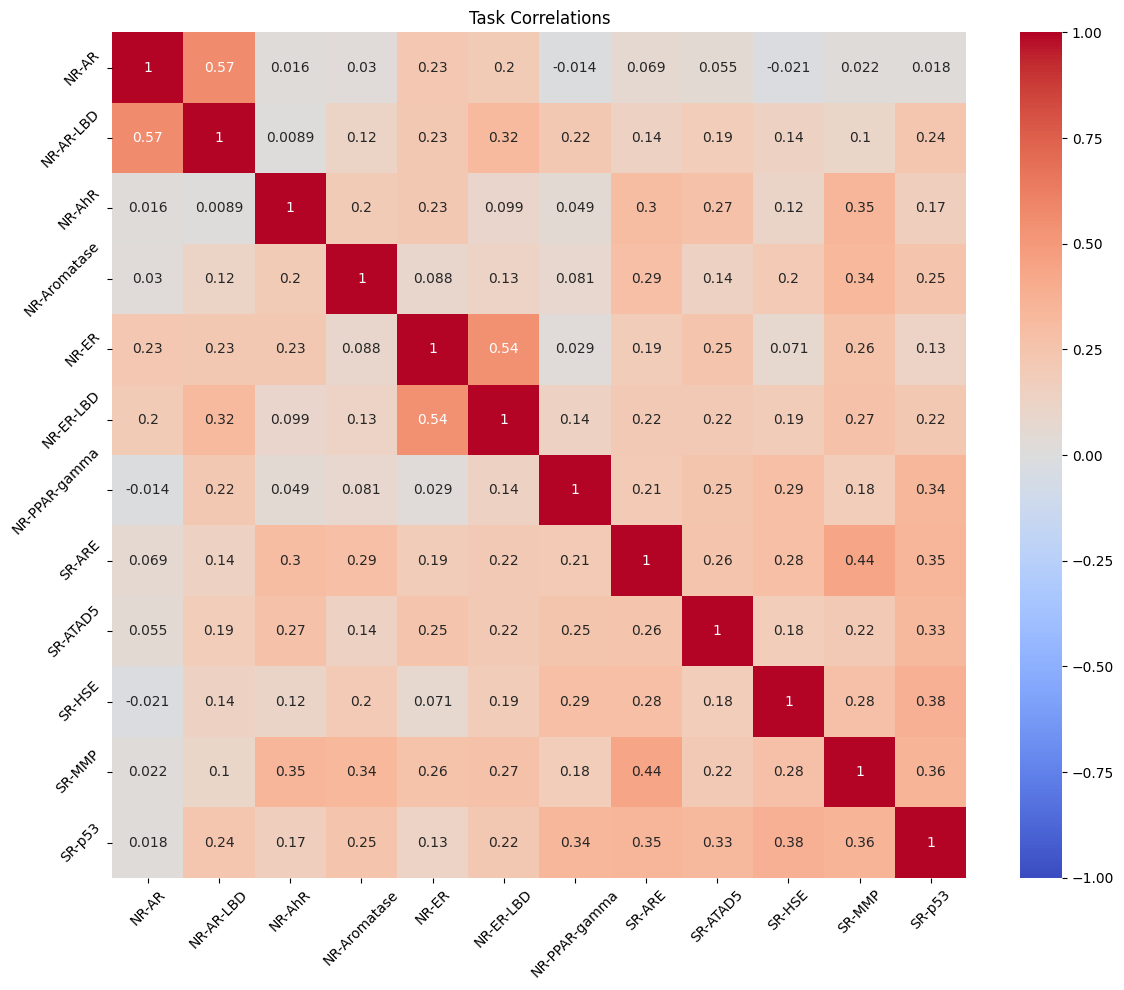

In [ ]:
#%% Task Correlations

print("\n=== Task Correlations ===")
# All labels
all_labels = torch.stack([data.y for data in dataset]).squeeze().numpy()
# Define task names
task_names = [
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER',
    'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5',
    'SR-HSE', 'SR-MMP', 'SR-p53'
]
# Calculate correlation matrix (ignoring missing values)
correlation_matrix = np.zeros((len(task_names), len(task_names)))

for i in range(len(task_names)):
    for j in range(len(task_names)):
        # Get valid indices (where both tasks have values)
        valid_indices = ~np.isnan(all_labels[:, i]) & ~np.isnan(all_labels[:, j])
        if valid_indices.sum() > 0:
            correlation_matrix[i, j] = np.corrcoef(
                all_labels[valid_indices, i],
                all_labels[valid_indices, j]
            )[0, 1]
#%% Plot correlation matrix

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            xticklabels=task_names, 
            yticklabels=task_names, 
            annot=True, 
            cmap='coolwarm',
            vmin=-1, 
            vmax=1)
plt.title('Task Correlations')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Analysis of Task Correlations in Tox21 Dataset

## Overview of Task Relationships
The correlation matrix reveals interesting patterns of relationships between different toxicity prediction tasks in the Tox21 dataset. These correlations provide insights into how different biological endpoints might be mechanistically related.

## Strong Correlations
The most notable strong correlation exists between NR-AR and NR-AR-LBD (correlation coefficient = 0.57), which makes biological sense since these tasks represent related androgen receptor endpoints. Similarly, NR-ER and NR-ER-LBD show a strong positive correlation (0.54), reflecting their shared estrogen receptor biology.

## Moderate Correlations
Several moderate correlations are observed between stress response pathway tasks:
- SR-ARE and SR-MMP show a correlation of 0.44, suggesting a potential link between oxidative stress response and mitochondrial membrane potential
- SR-p53 shows consistent moderate correlations (0.33-0.38) with other stress response pathways, indicating some shared mechanisms in cellular stress response

## Weak Correlations
Most nuclear receptor (NR) tasks show weak correlations with stress response (SR) tasks, with coefficients typically below 0.3. This suggests that these toxicity mechanisms operate relatively independently, which aligns with our understanding of distinct biological pathways.

## Implications for Modeling
These correlation patterns suggest that while some task pairs might benefit from multi-task learning approaches (especially within NR and SR groups), other tasks might be better handled independently. The moderate to strong correlations within pathway families (NR and SR) suggest potential benefits from transfer learning within these groups.

In [ ]:
#%% Summary Statistics

print("\n=== Summary Statistics ===")
print(f"Dataset size: {len(dataset)} molecules")
print("\nPer-task statistics:")

missing_values = []

for i, task in enumerate(task_names):
    # Count missing values
    missing = np.isnan(all_labels[:, i]).sum()
    missing_values.append(missing)

for i, task in enumerate(task_names):
    valid_labels = all_labels[:, i][~np.isnan(all_labels[:, i])]
    pos_rate = (valid_labels == 1).mean() if len(valid_labels) > 0 else 0
    missing_rate = missing_values[i] / len(dataset)
    
    print(f"\n{task}:")
    print(f"  - Positive rate: {pos_rate:.3f}")
    print(f"  - Missing rate: {missing_rate:.3f}")
    print(f"  - Total valid samples: {len(valid_labels)}")


=== Summary Statistics ===
Dataset size: 7831 molecules

Per-task statistics:

NR-AR:
  - Positive rate: 0.043
  - Missing rate: 0.072
  - Total valid samples: 7265

NR-AR-LBD:
  - Positive rate: 0.035
  - Missing rate: 0.137
  - Total valid samples: 6758

NR-AhR:
  - Positive rate: 0.117
  - Missing rate: 0.164
  - Total valid samples: 6549

NR-Aromatase:
  - Positive rate: 0.052
  - Missing rate: 0.257
  - Total valid samples: 5821

NR-ER:
  - Positive rate: 0.128
  - Missing rate: 0.209
  - Total valid samples: 6193

NR-ER-LBD:
  - Positive rate: 0.050
  - Missing rate: 0.112
  - Total valid samples: 6955

NR-PPAR-gamma:
  - Positive rate: 0.029
  - Missing rate: 0.176
  - Total valid samples: 6450

SR-ARE:
  - Positive rate: 0.162
  - Missing rate: 0.255
  - Total valid samples: 5832

SR-ATAD5:
  - Positive rate: 0.037
  - Missing rate: 0.097
  - Total valid samples: 7072

SR-HSE:
  - Positive rate: 0.058
  - Missing rate: 0.174
  - Total valid samples: 6467

SR-MMP:
  - Positive 

# Statistical Analysis of Tox21 Dataset Coverage and Class Distribution

## Data Availability Patterns
The dataset shows varying levels of data completeness across tasks. Valid samples range from 5,810 to 7,265 molecules per task, with missing rates spanning from 7.2% to 25.8%. Notable observations include:

### High Data Coverage Tasks
- NR-AR shows the highest coverage with 7,265 valid samples (7.2% missing)
- SR-ATAD5 follows closely with 7,072 valid samples (9.7% missing)
- NR-ER-LBD maintains good coverage with 6,955 valid samples (11.2% missing)

### Limited Data Coverage Tasks
- NR-Aromatase has 5,821 valid samples (25.7% missing)
- SR-MMP shows similar coverage with 5,810 valid samples (25.8% missing)
- SR-ARE contains 5,832 valid samples (25.5% missing)

## Class Imbalance Analysis
The dataset exhibits significant class imbalance across all tasks, with positive rates varying substantially:

### Higher Positive Rate Tasks
- SR-ARE leads with 16.2% positive samples
- SR-MMP follows at 15.8% positive samples
- NR-ER shows 12.8% positive samples
- NR-AhR contains 11.7% positive samples

### Lower Positive Rate Tasks
- NR-PPAR-gamma shows the lowest positive rate at 2.9%
- NR-AR-LBD follows at 3.5%
- SR-ATAD5 has 3.7% positive samples

## Implications for Model Development
These statistics suggest several important considerations for model development:

1. Data augmentation or balanced sampling strategies may be necessary, particularly for tasks with extreme class imbalance
2. Task-specific evaluation metrics should be chosen to account for the varying class distributions
3. Missing data handling strategies need to be carefully considered, especially for tasks with high missing rates
4. Model validation strategies should account for both the class imbalance and missing data patterns

Understanding these patterns is crucial for developing robust and reliable toxicity prediction models across all tasks.


=== Visualize Sample Molecules ===


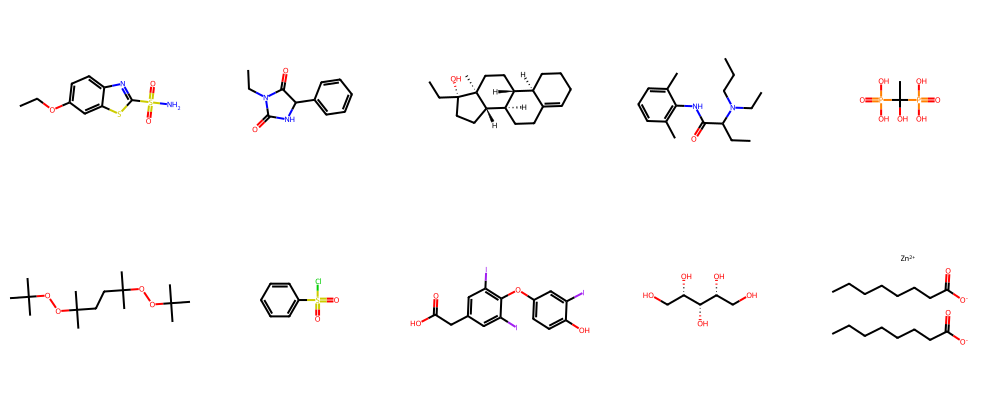

In [ ]:
#%% Visualize a sample of molecules

print("\n=== Visualize Sample Molecules ===")
sample_molecules = [dataset[i] for i in range(10)]
sample_smiles = [data.smiles for data in sample_molecules]
sample_mols = [Chem.MolFromSmiles(smiles) for smiles in sample_smiles]

img = Draw.MolsToGridImage(sample_mols, molsPerRow=5, subImgSize=(200, 200))
display(img)

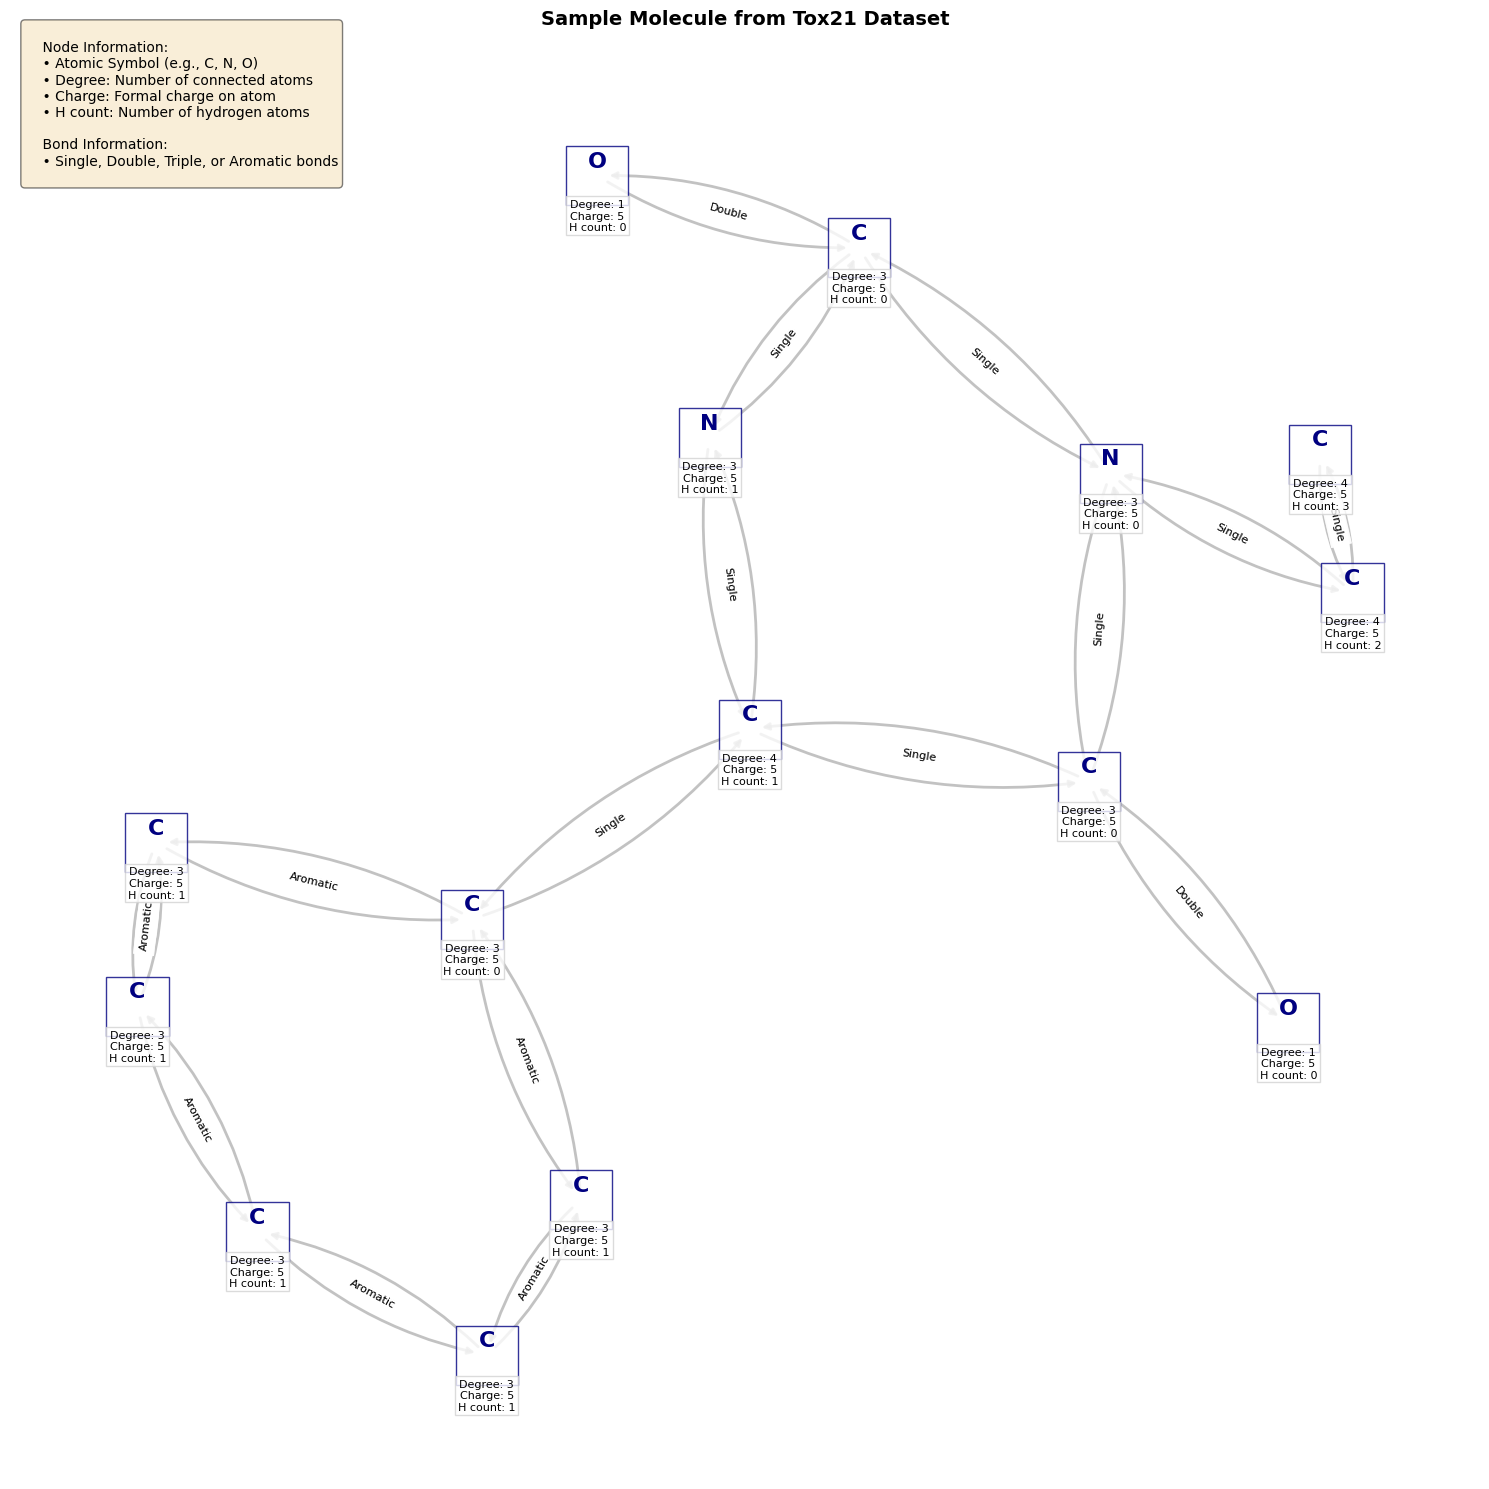

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def visualize_molecular_graph(sample_data, title='Molecular Graph Visualization'):
    """
    Creates a molecular graph visualization with highly readable node information using
    structured text boxes and clear atomic information display.
    
    Args:
        sample_data: PyG Data object containing the molecular graph
        title: String for the plot title
    """
    # Convert PyG data to NetworkX graph
    G = to_networkx(sample_data, node_attrs=['x'], edge_attrs=['edge_attr'])
    
    # Create a larger figure for better text spacing
    plt.figure(figsize=(15, 15), facecolor='white')
    
    # Use Kamada-Kawai layout for initial positioning
    pos_initial = nx.kamada_kawai_layout(G)
    
    # Refine with spring layout
    pos = nx.spring_layout(G, 
                          pos=pos_initial,
                          k=3.0,           # Increased spacing for text boxes
                          iterations=100,
                          scale=2.0)
    
    # Draw edges with slight curves
    nx.draw_networkx_edges(G, pos,
                          edge_color='darkgray',
                          width=2,
                          alpha=0.7,
                          connectionstyle="arc3,rad=0.15")
    
    # Dictionary to convert atomic numbers to symbols
    atomic_symbols = {
        6: 'C', 7: 'N', 8: 'O', 9: 'F', 
        15: 'P', 16: 'S', 17: 'Cl', 35: 'Br'
    }
    
    # Draw nodes and create structured labels
    for node in G.nodes():
        features = G.nodes[node]['x']
        atomic_num = int(features[0])
        
        # Create a white background box for the node
        node_box = Rectangle((pos[node][0] - 0.1, pos[node][1] - 0.1),
                           0.2, 0.2,
                           facecolor='white',
                           edgecolor='navy',
                           alpha=0.8,
                           zorder=1)
        plt.gca().add_patch(node_box)
        
        # Add atomic symbol in large font
        plt.text(pos[node][0], pos[node][1] + 0.05,
                atomic_symbols.get(atomic_num, str(atomic_num)),
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=16,
                fontweight='bold',
                color='navy',
                zorder=2)
        
        # Add structured property text below
        property_text = (
            f"Degree: {int(features[2])}\n"
            f"Charge: {int(features[3])}\n"
            f"H count: {int(features[4])}"
        )
        
        plt.text(pos[node][0], pos[node][1] - 0.08,
                property_text,
                horizontalalignment='center',
                verticalalignment='top',
                fontsize=8,
                bbox=dict(facecolor='white',
                         edgecolor='lightgray',
                         alpha=0.8,
                         pad=2),
                zorder=2)
    
    # Draw edge labels with bond information
    edge_labels = {}
    for (i, j) in G.edges:
        attrs = G.edges[i, j]['edge_attr']
        bond_type = attrs[0]
        # Convert numerical bond type to text
        bond_text = {1.0: 'Single', 2.0: 'Double', 
                    3.0: 'Triple', 12: 'Aromatic'}.get(bond_type, f'{bond_type:.1f}')
        edge_labels[(i, j)] = bond_text
    
    nx.draw_networkx_edge_labels(G, pos,
                                edge_labels=edge_labels,
                                font_size=8,
                                bbox=dict(facecolor='white',
                                         edgecolor='none',
                                         alpha=0.8))
    
    # Add informative legend
    legend_text = """
    Node Information:
    • Atomic Symbol (e.g., C, N, O)
    • Degree: Number of connected atoms
    • Charge: Formal charge on atom
    • H count: Number of hydrogen atoms
    
    Bond Information:
    • Single, Double, Triple, or Aromatic bonds
    """
    
    plt.gcf().text(0.02, 0.98, legend_text,
                   fontsize=10,
                   verticalalignment='top',
                   bbox=dict(facecolor='wheat',
                            alpha=0.5,
                            boxstyle='round'))
    
    plt.title(title, pad=20, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    
    return plt.gcf()

# Usage
sample_molecule = dataset[1]
visualize_molecular_graph(sample_molecule, "Sample Molecule from Tox21 Dataset")
plt.show()


=== Visualize Sample Molecules ===

=== Visualize canonical SMILES for the sample molecule ===


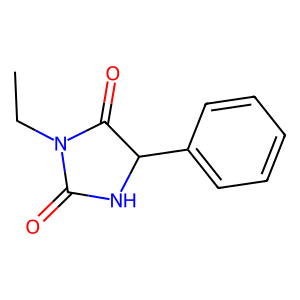

In [5]:
#%% Visualize the molecule
from Baseline.preprocessing import MolecularDescriptors

print("\n=== Visualize Sample Molecules ===")
sample_molecules = [dataset[i] for i in range(10)]
sample_smiles = [data.smiles for data in sample_molecules]
sample_mols = [Chem.MolFromSmiles(smiles) for smiles in sample_smiles]

img = Draw.MolsToGridImage(sample_mols, molsPerRow=5, subImgSize=(200, 200))
#display(img)

print("\n=== Visualize canonical SMILES for the sample molecule ===")
molecu = dataset[1]
molecule_smiles = molecu.smiles
molecule_mols = Chem.MolFromSmiles(molecule_smiles)

img = Draw.MolToImage(molecule_mols, molsPerRow=5, subImgSize=(200, 200))
display(img)

# Analysis of Molecular Graph and Chemical Structure Representations

## Overview
The figures present two complementary representations of a molecule from the Tox21 dataset: a graph-based representation optimized for machine learning and a traditional chemical structure drawing. This analysis explores how these different representations capture molecular information and their implications for toxicity prediction tasks.

## Graph Representation Features
The graph visualization reveals the molecular topology through a node-edge representation where:

The nodes (atoms) display several key properties:
- Atomic identity (C, N, O)
- Degree (number of connections to other atoms)
- Formal charge values
- Number of hydrogen atoms attached
- Spatial arrangement maintaining chemical connectivity

The edges (bonds) show:
- Bond types (single, double)
- Clear connectivity patterns between atoms
- Special encodings for the aromatic ring (12.0 value bonds)

## Comparison with Chemical Structure
The traditional chemical drawing provides the standard representation familiar to chemists, showing a hydantoin derivative with:
- A central five-membered ring containing two nitrogens
- Two carbonyl groups (C=O)
- A phenyl substituent
- An N-ethyl group

The graph representation successfully captures all these structural features while adding machine-learning-relevant annotations. However, some chemical features are encoded differently:
- Aromatic bonds are represented as single edges with special values rather than alternating single/double bonds
- Hydrogen atoms are stored as properties of heavy atoms rather than explicit nodes
- The NH group is encoded in the hydrogen count property of the nitrogen atom

## Implications for Toxicity Prediction
This dual representation system offers several advantages for toxicity prediction:
- The graph format provides explicit property values useful for machine learning
- The traditional structure allows chemists to verify chemical reasonableness
- The conversion between formats enables validation of data preprocessing steps
- The detailed node properties capture electronic and steric features relevant to toxicity

Understanding these complementary representations is crucial for developing and interpreting molecular graph-based models for toxicity prediction.